In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Passando ad highZ è sufficiente modificare
    model_version: 0107/lowZ/v* --> 0107/highZ/v*
    sample: DNN_v7/lowZ/test --> DNN_v7/highZ/test

In [2]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "model_version":   "0107/lowZ/v0", #Aggiornare modello
    "batch_size": 128,   #Inserire il batch_size corretto
    "test_size": 0.2,
}

In [3]:
sample = "DNN_v7/lowZ/test"

In [4]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])

In [5]:
import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [6]:
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples/", sample)
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

#### Per ottenere le ROC del modello applicato ai vari anni anni è sufficiente 
1. Commentare la casella sopra questa
2. Scommenta la casella sotto questa
3. Modificare la variabile "ye" di volta in volta (ricorda che è una stringa, non un int!)

Ricorda, per commentare e scommentare, seleziona e premi ``ctrl+ù``

In [7]:
# ye = "2016"
# samples_dir = os.path.join(config_base_dir, config["cut"] , "samples/", sample)
# import pickle
# signal = pickle.load(open(os.path.join(samples_dir, "for_training_"+ye+"/signal_balanced.pkl"),     "rb"))
# bkg    = pickle.load(open(os.path.join(samples_dir, "for_training_"+ye+"/background_balanced.pkl"), "rb"))

In [8]:
samples_dir

'/eos/home-b/bpinolin/ML_output/VBSOS/sr/samples/DNN_v7/highZ/test'

In [9]:
bkg = bkg.dropna()
signal = signal.dropna()

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

In [12]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

W0107 21:59:23.367379 139774569170752 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                950       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)               

In [13]:
y_pred = model.predict(X_scaled, batch_size=config["batch_size"])
y_pred = np.array(y_pred).flatten()

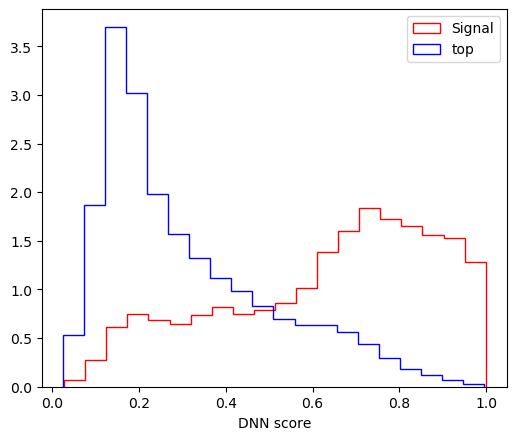

In [14]:
fig = plt.figure(figsize=(6,5), dpi=100)
_ = plt.hist(y_pred[Y==1], bins=20, lw = 1, histtype="step", label="Signal", color='red', density=True)
_ = plt.hist(y_pred[Y==0], bins=20, lw = 1, histtype="step", label="top", color='blue', density=True)
plt.legend(loc="upper right", fontsize=10)
plt.xlabel("DNN score", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(os.path.join(model_dir, "plots/DNN_score.pdf"))
plt.savefig(os.path.join(model_dir, "plots/DNN_score.png"))
plt.show()

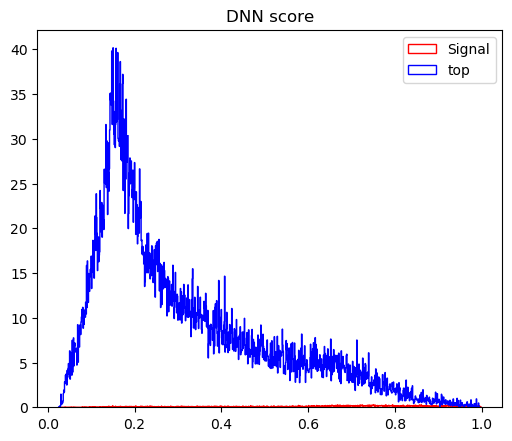

In [15]:
fig = plt.figure(figsize=(6,5), dpi=100)
n_sig, b, _ = plt.hist(y_pred[Y==1], bins=1000, histtype="step", weights=Wnn[Y==1], label="Signal", color='red')
n_bkg, b, _ = plt.hist(y_pred[Y==0], bins=1000, histtype="step", weights=Wnn[Y==0], label="top", color='blue')
plt.legend()
plt.title("DNN score")
plt.show()

In [16]:
effS = np.array([])
effB = np.array([])

for i in range(len(n_sig)):
    i = i+1
    S = sum(n_sig[-i:len(n_sig)])
    effS = np.append(effS, S/sum(n_sig))
    
for j in range(len(n_bkg)):
    j = j+1
    B = sum(n_bkg[-j:len(n_bkg)])
    effB = np.append(effB, B/sum(n_bkg))

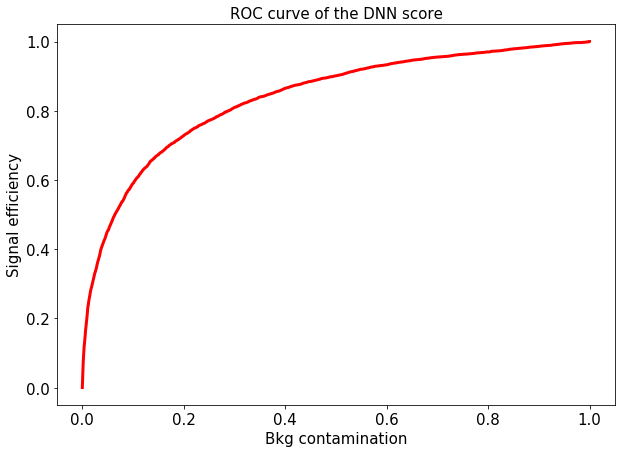

In [17]:
plt.figure(figsize=(10,7))
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel("Bkg contamination", fontsize=15)
plt.ylabel("Signal efficiency", fontsize=15)

plt.title("ROC curve of the DNN score", fontsize=15)
plt.plot(effB,effS,linewidth=3, color="red")
plt.show()

In [18]:
B = effB.tolist()
B.insert(0,0)

In [19]:
S = effS.tolist()
S.insert(0,0)

In [20]:
print(B)
print(S)

[0, 7.902493361440948e-06, 9.939727324617115e-06, 6.858651649281645e-05, 6.858651649281645e-05, 6.877642476096312e-05, 7.464862799522533e-05, 8.272499910711162e-05, 0.00019773328078428017, 0.00020655335945833742, 0.00020675130924251284, 0.00025035726369394986, 0.0002532833617937762, 0.00030346642328904554, 0.00030346642328904554, 0.0003164649053264796, 0.00032557856079234315, 0.0003268329429428995, 0.00036560449367692275, 0.00036560449367692275, 0.0003975584332598469, 0.0004997829601486168, 0.0005551585774850021, 0.0005769235744785498, 0.0005769235744785498, 0.0006120734171470141, 0.0006545590375367804, 0.0006917940033618583, 0.0006917940033618583, 0.0007129895524324259, 0.0007886720383917774, 0.0008212939900567912, 0.0008620447636090466, 0.0008943030176865271, 0.0009298050929748105, 0.0009704013571703472, 0.000979263022381672, 0.0010135227671003418, 0.0010322239069175743, 0.0010479230178740175, 0.0010680678223188103, 0.0011068679490866746, 0.0011704086061346277, 0.0012141363237109252,

## 2D plots: DNN vs btag_central

# 